<a href="https://colab.research.google.com/github/Wf-max/Wei-and-Yuxi-Deep-and-Generative-Learning/blob/main/Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
image_folder = "/content/drive/MyDrive/image"

In [21]:
import os
print(os.listdir(image_folder))

['1009.png', '1005.png', '1003.png', '1006.png', '1014.png', '1013.png', '1010.png', '1016.png', '1008.png', '1015.png', '1012.png', '1011.png', '1002.png', '1007.png', '1019.png', '1000.png', '1004.png', '1018.png', '1020.png', '1001.png', '1017.png', '1023.png', '1021.png', '1022.png', '1029.png', '1027.png', '1028.png', '1026.png', '1024.png', '1025.png', '1033.png', '1031.png', '1032.png', '1030.png', '1034.png', '1036.png', '1038.png', '1039.png', '1037.png', '1035.png', '1044.png', '1041.png', '1042.png', '1043.png', '1040.png', '1049.png', '1045.png', '1048.png', '1046.png', '1047.png', '1050.png', '1055.png', '1053.png', '1054.png', '1052.png', '1051.png', '1057.png', '1058.png', '1061.png', '1059.png', '1056.png', '1060.png', '1066.png', '1063.png', '1062.png', '1064.png', '1065.png', '1069.png', '1070.png', '1068.png', '1072.png', '1071.png', '1067.png', '1077.png', '1075.png', '1073.png', '1074.png', '1076.png', '1080.png', '1078.png', '1082.png', '1079.png', '1083.png', '10

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [23]:
class VAEEncoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAEEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 16 * 16, latent_dim)
        self.fc_logvar = nn.Linear(128 * 16 * 16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class VAEDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAEDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 16 * 16)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def forward(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 128, 16, 16)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))
        return x

class VAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar, z

class VAEClassifier(nn.Module):
    def __init__(self, latent_dim=64):
        super(VAEClassifier, self).__init__()
        self.vae = VAE(latent_dim)
        self.classifier = nn.Linear(latent_dim, 2)

    def forward(self, x):
        recon_x, mu, logvar, z = self.vae(x)
        class_logits = self.classifier(z)
        return recon_x, mu, logvar, class_logits


In [24]:
def vae_classification_loss(recon_x, x, mu, logvar, class_logits, labels, beta=1.0):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = F.cross_entropy(class_logits, labels)
    total_loss = recon_loss + beta * kl_loss + class_loss
    return total_loss, recon_loss, kl_loss, class_loss


In [25]:
class TBChestXrayDatasetFromCSV(Dataset):
    def __init__(self, csv_path, images_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = str(row['id'])
        label = int(row['ptb'])

        img_path = os.path.join(self.images_dir, img_id + ".png")

        try:
            image = Image.open(img_path).convert('L')
        except FileNotFoundError:

            print(f"Warning: File {img_path} not found, skipping...")
            return self.__getitem__((idx + 1) % len(self.data))

        if self.transform:
            image = self.transform(image)

        return image, label



In [26]:
# Your data paths
csv_path = "/content/MetaData_gender_updated.csv"
images_dir =  "/content/drive/MyDrive/image"

# Hyperparameters
latent_dim = 64
learning_rate = 1e-3
batch_size = 32
num_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Dataset and DataLoader
dataset = TBChestXrayDatasetFromCSV(csv_path=csv_path, images_dir=images_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model = VAEClassifier(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [27]:
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar, class_logits = model(images)
        loss, recon_loss, kl_loss, class_loss = vae_classification_loss(recon_images, images, mu, logvar, class_logits, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        preds = torch.argmax(class_logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)

    model.eval()
    val_losses = []
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            recon_images, mu, logvar, class_logits = model(images)
            loss, _, _, _ = vae_classification_loss(recon_images, images, mu, logvar, class_logits, labels)
            val_losses.append(loss.item())

            preds = torch.argmax(class_logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {sum(train_losses)/len(train_losses):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {sum(val_losses)/len(val_losses):.4f}, Val Acc: {val_acc:.4f}")

    train_loss_history.append(sum(train_losses) / len(train_losses))
    train_acc_history.append(train_acc)
    val_loss_history.append(sum(val_losses) / len(val_losses))
    val_acc_history.append(val_acc)


Epoch [1/30] - Train Loss: 348284.9766, Train Acc: 0.5372, Val Loss: 354185.8750, Val Acc: 0.6452
Epoch [2/30] - Train Loss: 338964.9844, Train Acc: 0.4793, Val Loss: 342395.2500, Val Acc: 0.4194
Epoch [3/30] - Train Loss: 329307.9570, Train Acc: 0.5041, Val Loss: 332311.5312, Val Acc: 0.4516
Epoch [4/30] - Train Loss: 319695.5391, Train Acc: 0.4876, Val Loss: 318174.1875, Val Acc: 0.5161
Epoch [5/30] - Train Loss: 312236.2695, Train Acc: 0.5041, Val Loss: 318794.7812, Val Acc: 0.4839
Epoch [6/30] - Train Loss: 311484.2656, Train Acc: 0.4215, Val Loss: 317237.9688, Val Acc: 0.6129
Epoch [7/30] - Train Loss: 310115.1641, Train Acc: 0.4628, Val Loss: 313881.6562, Val Acc: 0.5806
Epoch [8/30] - Train Loss: 308446.8672, Train Acc: 0.5537, Val Loss: 313048.4375, Val Acc: 0.4839
Epoch [9/30] - Train Loss: 307237.3008, Train Acc: 0.5041, Val Loss: 312418.8438, Val Acc: 0.5806
Epoch [10/30] - Train Loss: 305932.4688, Train Acc: 0.4215, Val Loss: 310052.3438, Val Acc: 0.4839
Epoch [11/30] - Tra

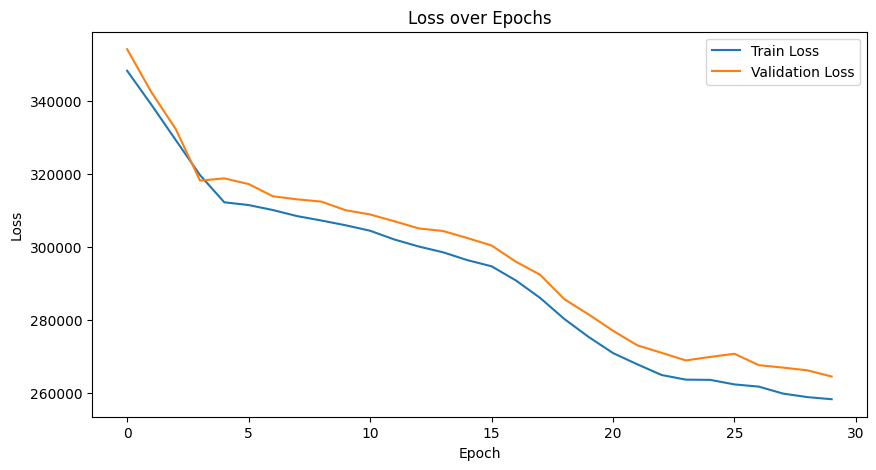

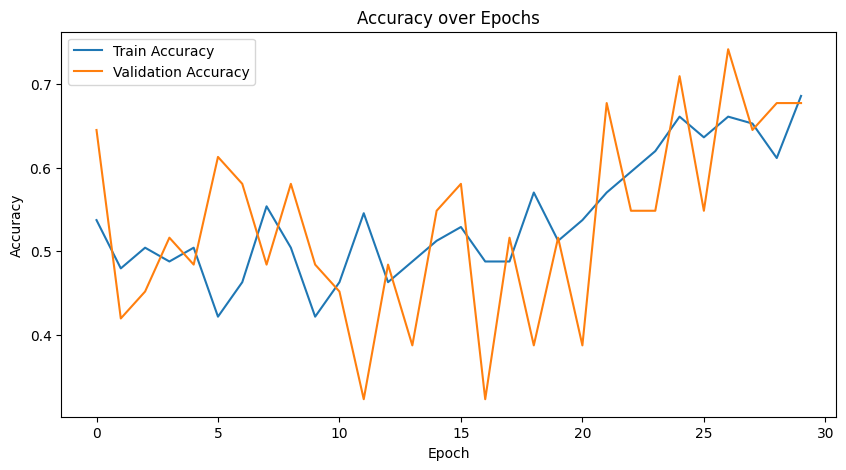

In [28]:
# Loss curve
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(10,5))
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


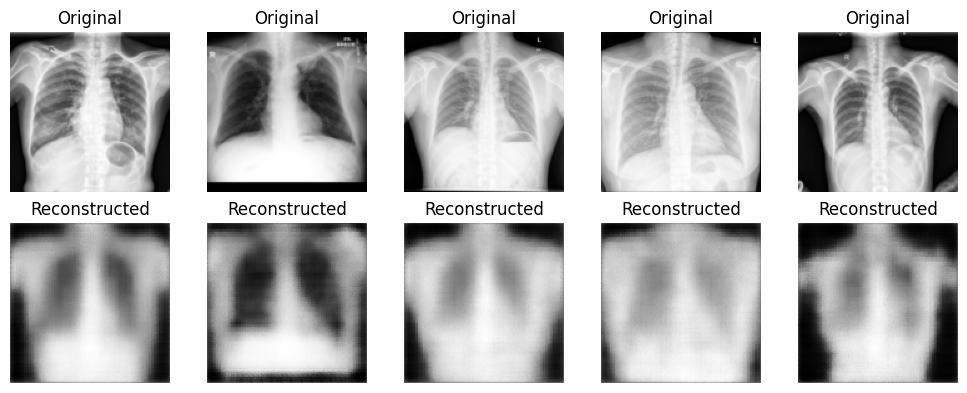

In [30]:
# Visualize Original vs Reconstructed Images
images, labels = next(iter(val_loader))
images = images.to(device)

model.eval()
with torch.no_grad():
    recon_images, _, _, _ = model(images)

n = min(5, images.size(0))
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
recon_images_list = []
labels_list = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        recon_images, _, _, _ = model(images)

        recon_images_list.append(recon_images.cpu())
        labels_list.append(labels.cpu())


recon_images_all = torch.cat(recon_images_list, dim=0)
labels_all = torch.cat(labels_list, dim=0)


In [32]:
class SimpleCNNClassifier(nn.Module):
    def __init__(self):
        super(SimpleCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [33]:
from torch.utils.data import TensorDataset


recon_dataset = TensorDataset(recon_images_all, labels_all)

train_size = int(0.8 * len(recon_dataset))
val_size = len(recon_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(recon_dataset, [train_size, val_size])

train_loader_recon = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader_recon = DataLoader(val_set, batch_size=32, shuffle=False)


In [34]:
model_recon = SimpleCNNClassifier().to(device)
optimizer = optim.Adam(model_recon.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model_recon.train()
    train_loss = 0

    for images, labels in train_loader_recon:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_recon(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}: Train Loss = {train_loss/len(train_loader_recon):.4f}")


Epoch 1: Train Loss = 0.6807
Epoch 2: Train Loss = 1.7023
Epoch 3: Train Loss = 0.6720
Epoch 4: Train Loss = 0.7968
Epoch 5: Train Loss = 0.7374
Epoch 6: Train Loss = 0.6886
Epoch 7: Train Loss = 0.6652
Epoch 8: Train Loss = 0.6569
Epoch 9: Train Loss = 0.6499
Epoch 10: Train Loss = 0.6419


In [35]:
model_recon.eval()
val_preds = []
val_labels = []

with torch.no_grad():
    for images, labels in val_loader_recon:
        images, labels = images.to(device), labels.to(device)
        outputs = model_recon(images)
        preds = torch.argmax(outputs, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

val_acc = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy on Reconstructed Images: {val_acc:.4f}")


Validation Accuracy on Reconstructed Images: 0.5714
